In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
import time
import warnings


In [2]:
df = pd.read_csv("phishOFE_ds.csv")
df.dtypes

URL                      object
IsHTTPS                   int64
IsDomainIP                int64
TLD                      object
URLLength                 int64
NoOfSubDomain             int64
NoOfDots                  int64
NoOfObfuscatedChar        int64
NoOfEqual                 int64
NoOfQmark                 int64
NoOfAmp                   int64
NoOfDigits                int64
LineLength                int64
HasTitle                  int64
HasMeta                   int64
HasFavicon                int64
HasExternalFormSubmit     int64
HasCopyright              int64
HasSocialNetworking       int64
HasPasswordField          int64
HasSubmitButton           int64
HasKeywordBank            int64
HasKeywordPay             int64
HasKeywordCrypto          int64
NoOfPopup                 int64
NoOfiFrame                int64
NoOfImage                 int64
NoOfJS                    int64
NoOfCSS                   int64
NoOfURLRedirect           int64
NoOfHyperlink             int64
label   

In [3]:
def SuspiciousCharRatio(data):
    data['SuspiciousCharRatio'] = (
            data['NoOfObfuscatedChar'] +
            data['NoOfEqual'] +
            data['NoOfQmark'] +
            data['NoOfAmp']
        ) / data['URLLength']
    return data

In [4]:
def URLComplexityScore(data):
    # Calculate the first term: (URLLength + NoOfSubDomain + NoOfObfuscatedChar) / URLLength
    first_term = (
        data['URLLength'] + 
        data['NoOfSubDomain'] + 
        data['NoOfObfuscatedChar']
    ) / data['URLLength']   

    # Calculate the second term: (NoOfEqual + NoOfAmp) / (NoOfQmark + 1)
    second_term = (
        data['NoOfEqual'] + 
        data['NoOfAmp']
    ) / (data['NoOfQmark'] + 1)

    data['URLComplexityScore'] = first_term + second_term
    
    return data

In [5]:
def HTMLContentDensity(data):
    data['HTMLContentDensity'] = (
            data['LineLength'] + data['NoOfImage']
        ) / (
            data['NoOfJS'] + data['NoOfCSS'] + data['NoOfiFrame'] + 1
        )    
    return data

In [6]:
def InteractiveElementDensity(data):
    data['InteractiveElementDensity'] = (
            data['HasSubmitButton'] +
            data['HasPasswordField'] +
            data['NoOfPopup']
        ) / (
            data['LineLength'] + data['NoOfImage']
        )
    return data

In [7]:
df = SuspiciousCharRatio(df)
df = URLComplexityScore(df)
df = HTMLContentDensity(df)
df = InteractiveElementDensity(df)
df.dtypes

URL                           object
IsHTTPS                        int64
IsDomainIP                     int64
TLD                           object
URLLength                      int64
NoOfSubDomain                  int64
NoOfDots                       int64
NoOfObfuscatedChar             int64
NoOfEqual                      int64
NoOfQmark                      int64
NoOfAmp                        int64
NoOfDigits                     int64
LineLength                     int64
HasTitle                       int64
HasMeta                        int64
HasFavicon                     int64
HasExternalFormSubmit          int64
HasCopyright                   int64
HasSocialNetworking            int64
HasPasswordField               int64
HasSubmitButton                int64
HasKeywordBank                 int64
HasKeywordPay                  int64
HasKeywordCrypto               int64
NoOfPopup                      int64
NoOfiFrame                     int64
NoOfImage                      int64
N

### df.info()

In [9]:
#description of dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IsHTTPS,101063.0,0.973274,0.161282,0.000000,1.000000,1.000000,1.000000,1.000000e+00
IsDomainIP,101063.0,0.002602,0.050947,0.000000,0.000000,0.000000,0.000000,1.000000e+00
URLLength,101063.0,42.180323,122.796863,12.000000,23.000000,27.000000,37.000000,2.552300e+04
NoOfSubDomain,101063.0,0.944945,0.481081,0.000000,1.000000,1.000000,1.000000,1.000000e+01
NoOfDots,101063.0,2.059280,0.802533,1.000000,2.000000,2.000000,2.000000,2.300000e+01
NoOfObfuscatedChar,101063.0,0.505506,1.899502,0.000000,0.000000,0.000000,1.000000,1.940000e+02
NoOfEqual,101063.0,0.257968,1.141472,0.000000,0.000000,0.000000,0.000000,4.700000e+01
NoOfQmark,101063.0,0.088588,0.305593,0.000000,0.000000,0.000000,0.000000,1.700000e+01
NoOfAmp,101063.0,0.170557,0.883987,0.000000,0.000000,0.000000,0.000000,4.300000e+01
NoOfDigits,101063.0,3.181748,17.701250,0.000000,0.000000,0.000000,2.000000,3.413000e+03


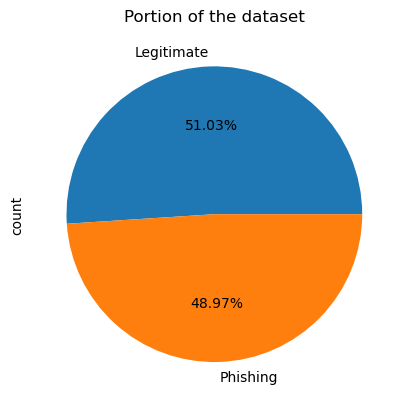

In [10]:
# Phishing Count in pie chart

df['label'].value_counts().plot(kind='pie', labels=['Legitimate', 'Phishing'], autopct='%1.2f%%')
plt.title("Portion of the dataset")
plt.show()

In [11]:
df.head()

,URL,IsHTTPS,IsDomainIP,TLD,URLLength,NoOfSubDomain,NoOfDots,NoOfObfuscatedChar,NoOfEqual,NoOfQmark,...,NoOfImage,NoOfJS,NoOfCSS,NoOfURLRedirect,NoOfHyperlink,label,SuspiciousCharRatio,URLComplexityScore,HTMLContentDensity,InteractiveElementDensity
0,https://www.fow.kr,1,0,kr,18,1,2,0,0,0,...,81,16,2,2,57,0,0.0,1.055556,40.526316,0.001299
1,https://www.visa.com.ar,1,0,ar,23,2,3,0,0,0,...,11,31,10,0,11,0,0.0,1.086957,8.214286,0.000000
2,https://www.inflibnet.ac.in,1,0,in,27,2,3,0,0,0,...,42,26,10,0,229,0,0.0,1.074074,23.868421,0.000000
3,https://www.lyrsense.com,1,0,com,24,1,2,0,0,0,...,106,14,1,1,331,0,0.0,1.041667,18.937500,0.000000
4,https://www.61saat.com,1,0,com,22,1,2,0,0,0,...,79,46,4,0,275,0,0.0,1.045455,340.403846,0.000056


In [12]:
# Define features and target
#X = df.drop(columns=['label','URL'])  # Drop non-numeric and irrelevant columns

d = defaultdict(LabelEncoder)
df = df.apply(lambda x: d[x.name].fit_transform(x))

df_FS = df.copy()

# Define 'y' as the target variable (label column)
y = df_FS['label']
X = df_FS.drop(columns=['label','URL']) # Target variable: 1 for phishing, 0 for legitimate

#colnames = X.columns
#X.head()
df.head()

,URL,IsHTTPS,IsDomainIP,TLD,URLLength,NoOfSubDomain,NoOfDots,NoOfObfuscatedChar,NoOfEqual,NoOfQmark,...,NoOfImage,NoOfJS,NoOfCSS,NoOfURLRedirect,NoOfHyperlink,label,SuspiciousCharRatio,URLComplexityScore,HTMLContentDensity,InteractiveElementDensity
0,64790,1,0,218,5,1,1,0,0,0,...,81,16,2,2,57,0,0,309,5677,21372
1,96993,1,0,49,10,2,2,0,0,0,...,11,31,10,0,11,0,0,404,270,0
2,70121,1,0,200,14,2,2,0,0,0,...,42,26,10,0,229,0,0,370,3110,0
3,75182,1,0,111,11,1,1,0,0,0,...,106,14,1,1,331,0,0,249,2201,0
4,48513,1,0,111,9,1,1,0,0,0,...,79,46,4,0,275,0,0,264,20028,7205


In [13]:
# Define a ranking function
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order * np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

# Initialize RandomForestClassifier for Boruta
rf = RandomForestClassifier(
    n_jobs=-1, 
    class_weight="balanced_subsample", 
    max_depth=5, 
    n_estimators="auto"  # Adjust n_estimators to a specific value since 'auto' is not valid for this parameter
)

# Initialize Boruta Feature Selector
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1)

# Fit Boruta to the dataset
feat_selector.fit(X.values, y.values.ravel())

# Generate feature rankings
boruta_score = ranking(
    list(map(float, feat_selector.ranking_)), 
    X.columns,  # Use X.columns to provide feature names
    order=-1
)

# Convert rankings into a DataFrame
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending=False)

# Display the rankings
print(boruta_score)

                     Features  Score
0                     IsHTTPS    1.0
18           HasPasswordField    1.0
32         HTMLContentDensity    1.0
31         URLComplexityScore    1.0
30        SuspiciousCharRatio    1.0
29              NoOfHyperlink    1.0
28            NoOfURLRedirect    1.0
27                    NoOfCSS    1.0
26                     NoOfJS    1.0
25                  NoOfImage    1.0
24                 NoOfiFrame    1.0
23                  NoOfPopup    1.0
22           HasKeywordCrypto    1.0
21              HasKeywordPay    1.0
20             HasKeywordBank    1.0
19            HasSubmitButton    1.0
17        HasSocialNetworking    1.0
9                     NoOfAmp    1.0
8                   NoOfQmark    1.0
2                         TLD    1.0
3                   URLLength    1.0
4               NoOfSubDomain    1.0
5                    NoOfDots    1.0
6          NoOfObfuscatedChar    1.0
7                   NoOfEqual    1.0
33  InteractiveElementDensity    1.0
1

In [14]:
selected_features = X.columns[feat_selector.support_].tolist()

# Use only the selected features
X_selected = X[selected_features]
print("Selected Features: ", selected_features)

Selected Features:  ['IsHTTPS', 'TLD', 'URLLength', 'NoOfSubDomain', 'NoOfDots', 'NoOfObfuscatedChar', 'NoOfEqual', 'NoOfQmark', 'NoOfAmp', 'NoOfDigits', 'LineLength', 'HasTitle', 'HasMeta', 'HasFavicon', 'HasExternalFormSubmit', 'HasCopyright', 'HasSocialNetworking', 'HasPasswordField', 'HasSubmitButton', 'HasKeywordBank', 'HasKeywordPay', 'HasKeywordCrypto', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfJS', 'NoOfCSS', 'NoOfURLRedirect', 'NoOfHyperlink', 'SuspiciousCharRatio', 'URLComplexityScore', 'HTMLContentDensity', 'InteractiveElementDensity']


In [15]:
# Creating holders to store the model performance results
ML_Model = []
ML_Model2 = []
accuracy = []
f1_score = []
recall = []
precision = []
mcc = []
training_time =[]
prediction_time = []

# Creating holders to store the model performance results for multiple runs
rf_accuracy = []
nb_accuracy = []
kNN_accuracy = []
lr_accuracy = []
dt_accuracy = []
svm_accuracy = []
gb_accuracy = []
lgbm_accuracy = []
xgb_accuracy = []
catB_accuracy = []

rf_precision = []
nb_precision = []
kNN_precision = []
lr_precision = []
dt_precision = []
svm_precision = []
gb_precision = []
lgbm_precision = []
xgb_precision = []
catB_precision = []

rf_recall = []
nb_recall = []
kNN_recall = []
lr_recall = []
dt_recall = []
svm_recall = []
gb_recall = []
lgbm_recall = []
xgb_recall = []
catB_recall = []

rf_f1 = []
nb_f1 = []
kNN_f1 = []
lr_f1 = []
dt_f1 = []
svm_f1 = []
gb_f1 = []
lgbm_f1 = []
xgb_f1 = []
catB_f1 = []

rf_mcc = []
nb_mcc = []
kNN_mcc = []
lr_mcc = []
dt_mcc = []
svm_mcc = []
gb_mcc = []
lgbm_mcc = []
xgb_mcc = []
catB_mcc = []

#function to call for storing the results
def storeResults(model, a,b,c,d,m):
  ML_Model.append(model)
  accuracy.append(round(a, 4))
  f1_score.append(round(b, 4))
  recall.append(round(c, 4))
  precision.append(round(d, 4))
  mcc.append(round(m, 4))

def storeResults2(model, e,f):
  ML_Model2.append(model)
  training_time.append(round(e, 4))
  prediction_time.append(round(f, 4))

#number of prepeated runs
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
warnings.filterwarnings("ignore")

# Split for model training

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80850, 33), (80850,), (20213, 33), (20213,))

# Random Forest

In [19]:
# Random Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5, random_state=10)

# Define hyperparameter grid
param_rf = {
    'n_estimators': [50, 100],  
    'max_depth': [3, 5],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 5],  
    'max_features': ['sqrt', 'log2']
}

# Perform GridSearchCV
grid_searchRF = GridSearchCV(
    estimator=forest, 
    param_grid=param_rf, 
    cv=3, 
    n_jobs=-1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchRF.fit(X_train, y_train)

#Train the best model on the training set
best_rf = grid_searchRF.best_estimator_
start_training = time.time()
best_rf.fit(X_train, y_train)
end_training = time.time()
rf_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
#y_train_forest = best_rf.predict(X_train)
y_test_forest = best_rf.predict(X_test)
end_prediction = time.time()
rf_prediction_time = end_prediction - start_prediction

In [20]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_forest = metrics.accuracy_score(y_test,y_test_forest)
f1_score_test_forest = metrics.f1_score(y_test,y_test_forest)
recall_score_test_forest= metrics.recall_score(y_test,y_test_forest)
precision_score_test_forest = metrics.precision_score(y_test,y_test_forest)
mcc_test_forest = metrics.matthews_corrcoef(y_test, y_test_forest)

print("Accuracy: {:.3f}".format(acc_test_forest))
print("Precision: {:.3f}".format(precision_score_test_forest))
print("Recall: {:.3f}".format(recall_score_test_forest))
print("F1 Score: {:.3f}".format(f1_score_test_forest))
print("MCC): {:.3f}".format(mcc_test_forest))

Accuracy: 0.957
Precision: 0.967
Recall: 0.943
F1 Score: 0.955
MCC): 0.913


In [21]:
print(f"Training Time: {rf_training_time:.4f} ms")
print(f"Prediction Time: {rf_prediction_time:.4f} ms")

Training Time: 2.8625 ms
Prediction Time: 0.0474 ms


In [22]:
storeResults('Random Forest',acc_test_forest,f1_score_test_forest,
             recall_score_test_forest,precision_score_test_forest, mcc_test_forest)

storeResults2('Random Forest', rf_training_time,rf_prediction_time)

## Random Forest with 10-Fold Cross-Validation

In [24]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV on training data
    grid_searchRF.fit(X_train, y_train)

    #Train the best model on the training set
    best_rf = grid_searchRF.best_estimator_
    best_rf.fit(X_train, y_train)
    y_test_forest = best_rf.predict(X_test)
    
    rf_accuracy.append(round(metrics.accuracy_score(y_test, y_test_forest), 4))
    rf_precision.append(round(metrics.precision_score(y_test, y_test_forest), 4))
    rf_recall.append(round(metrics.recall_score(y_test, y_test_forest), 4))
    rf_f1.append(round(metrics.f1_score(y_test, y_test_forest), 4))
    rf_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_forest), 4))

In [25]:
df_rf = pd.DataFrame({
    "Accuracy": rf_accuracy,
    "Precision": rf_precision,
    "Recall": rf_recall,
    "F1-Score": rf_f1,
    "MCC": rf_mcc
})
print(df_rf)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9632     0.9689  0.9555    0.9622  0.9264
1    0.9673     0.9672  0.9659    0.9665  0.9345
2    0.9651     0.9680  0.9604    0.9642  0.9301
3    0.9674     0.9695  0.9638    0.9667  0.9349
4    0.9710     0.9694  0.9715    0.9704  0.9420
5    0.9687     0.9707  0.9652    0.9680  0.9374
6    0.9676     0.9699  0.9638    0.9669  0.9353
7    0.9680     0.9728  0.9616    0.9672  0.9361
8    0.9659     0.9727  0.9572    0.9649  0.9318
9    0.9664     0.9685  0.9626    0.9655  0.9327


# Naive Bayes

In [213]:
# Naive Bayes Classifier Model
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# instantiate the model
nb= GaussianNB()

param_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

# Perform GridSearchCV
grid_searchNB = GridSearchCV(
    estimator=nb, 
    param_grid=param_nb, 
    cv=3,  
    n_jobs=-1, 
    verbose=0
)
# fit the model 
grid_searchNB.fit(X_train, y_train)

# Train the best model on the training set
best_nb = grid_searchNB.best_estimator_
start_training = time.time()
best_nb.fit(X_train, y_train)
end_training = time.time()
nb_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_nb = best_nb.predict(X_test)
end_prediction = time.time()
nb_prediction_time = end_prediction - start_prediction

In [214]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_nb = metrics.accuracy_score(y_test,y_test_nb)
f1_score_test_nb = metrics.f1_score(y_test,y_test_nb)
recall_score_test_nb = metrics.recall_score(y_test,y_test_nb)
precision_score_test_nb = metrics.precision_score(y_test,y_test_nb)
mcc_test_nb = metrics.matthews_corrcoef(y_test, y_test_nb)

print("Accuracy: {:.3f}".format(acc_test_nb))
print("Precision: {:.3f}".format(precision_score_test_nb))
print("Recall: {:.3f}".format(recall_score_test_nb))
print("F1 Score: {:.3f}".format(f1_score_test_nb))
print("MCC): {:.3f}".format(mcc_test_nb))

Accuracy: 0.908
Precision: 0.943
Recall: 0.864
F1 Score: 0.902
MCC): 0.818


In [215]:
print(f"Training Time: {nb_training_time:.4f} ms")
print(f"Prediction Time: {nb_prediction_time:.4f} ms")

Training Time: 0.0862 ms
Prediction Time: 0.0112 ms


In [30]:
storeResults('Naive Bayes',acc_test_nb,f1_score_test_nb,
             recall_score_test_nb,precision_score_test_nb, mcc_test_nb)

storeResults2('Naive Bayes', nb_training_time,nb_prediction_time)

## Naive Bayes with 10-Fold Cross-Validation

In [32]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit the model 
    grid_searchNB.fit(X_train, y_train)

    #Train the best model on the training set
    best_nb = grid_searchNB.best_estimator_
    best_nb.fit(X_train, y_train)
    y_test_nb = best_nb.predict(X_test)
    
    nb_accuracy.append(round(metrics.accuracy_score(y_test, y_test_nb), 4))
    nb_precision.append(round(metrics.precision_score(y_test, y_test_nb), 4))
    nb_recall.append(round(metrics.recall_score(y_test, y_test_nb), 4))
    nb_f1.append(round(metrics.f1_score(y_test, y_test_nb), 4))
    nb_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_nb), 4))

In [33]:
df_nb = pd.DataFrame({
    "Accuracy": nb_accuracy,
    "Precision": nb_precision,
    "Recall": nb_recall,
    "F1-Score": nb_f1,
    "MCC": nb_mcc
})
print(df_nb)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9087     0.9442  0.8646    0.9026  0.8198
1    0.9102     0.9463  0.8656    0.9042  0.8228
2    0.9061     0.9431  0.8602    0.8997  0.8148
3    0.9116     0.9451  0.8701    0.9060  0.8254
4    0.9088     0.9418  0.8672    0.9030  0.8196
5    0.9107     0.9452  0.8681    0.9050  0.8238
6    0.9128     0.9426  0.8753    0.9077  0.8274
7    0.9136     0.9471  0.8723    0.9082  0.8294
8    0.9084     0.9441  0.8640    0.9023  0.8192
9    0.9077     0.9431  0.8636    0.9016  0.8178


# K-Nearest Neighbors

In [35]:
# K-Nearest Neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier()

# Define hyperparameter grid
param_knn = {
    'n_neighbors': [3, 5],  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

# Perform GridSearchCV
grid_searchKNN = GridSearchCV(
    estimator=knn, 
    param_grid=param_knn, 
    cv=3, 
    n_jobs=1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchKNN.fit(X_train, y_train)

# Train the best model on the training set
best_knn = grid_searchKNN.best_estimator_
start_training = time.time()
best_knn.fit(X_train, y_train)
end_training = time.time()
knn_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_knn = best_knn.predict(X_test)
end_prediction = time.time()

knn_prediction_time = end_prediction - start_prediction

In [36]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_knn = metrics.accuracy_score(y_test,y_test_knn)
f1_score_test_knn = metrics.f1_score(y_test,y_test_knn)
recall_score_test_knn = metrics.recall_score(y_test,y_test_knn)
precision_score_test_knn = metrics.precision_score(y_test,y_test_knn)
mcc_test_knn = metrics.matthews_corrcoef(y_test, y_test_knn)

print("Accuracy: {:.3f}".format(acc_test_knn))
print("Precision: {:.3f}".format(precision_score_test_knn))
print("Recall: {:.3f}".format(recall_score_test_knn))
print("F1 Score: {:.3f}".format(f1_score_test_knn))
print("MCC): {:.3f}".format(mcc_test_knn))

Accuracy: 0.957
Precision: 0.960
Recall: 0.952
F1 Score: 0.956
MCC): 0.914


In [37]:
print(f"Training Time: {knn_training_time:.4f} ms")
print(f"Prediction Time: {knn_prediction_time:.4f} ms")

Training Time: 0.0320 ms
Prediction Time: 16.2897 ms


In [38]:
storeResults('K-Nearest Neighbors',acc_test_knn,f1_score_test_knn,
             recall_score_test_knn,precision_score_test_knn, mcc_test_knn)

storeResults2('K-Nearest Neighbors',knn_training_time,knn_prediction_time)

## K-Nearest Neighbors with 10-Fold Cross-Validation

In [40]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV on training data
    grid_searchKNN.fit(X_train, y_train)

    #Train the best model on the training set
    best_knn = grid_searchKNN.best_estimator_
    best_knn.fit(X_train, y_train)
    y_test_knn = best_knn.predict(X_test)
    
    kNN_accuracy.append(round(metrics.accuracy_score(y_test, y_test_knn), 4))
    kNN_precision.append(round(metrics.precision_score(y_test, y_test_knn), 4))
    kNN_recall.append(round(metrics.recall_score(y_test, y_test_knn), 4))
    kNN_f1.append(round(metrics.f1_score(y_test, y_test_knn), 4))
    kNN_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_knn), 4))

In [41]:
df_kNN = pd.DataFrame({
    "Accuracy": kNN_accuracy,
    "Precision": kNN_precision,
    "Recall": kNN_recall,
    "F1-Score": kNN_f1,
    "MCC": kNN_mcc
})
print(df_kNN)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9571     0.9565  0.9557    0.9561  0.9141
1    0.9539     0.9579  0.9475    0.9527  0.9078
2    0.9578     0.9629  0.9503    0.9566  0.9155
3    0.9555     0.9607  0.9479    0.9542  0.9110
4    0.9575     0.9618  0.9509    0.9563  0.9149
5    0.9563     0.9615  0.9487    0.9550  0.9125
6    0.9557     0.9573  0.9519    0.9546  0.9113
7    0.9595     0.9619  0.9551    0.9585  0.9190
8    0.9570     0.9642  0.9473    0.9557  0.9140
9    0.9573     0.9603  0.9521    0.9562  0.9145


# Decision Tree

In [43]:
# Decision Tree Classifier model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid
param_tree = {
    'max_depth': [50, 100], 
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],
    'criterion': ['gini'],
    'max_features': ['sqrt']
}

# Perform GridSearchCV
grid_searchDT = GridSearchCV(
    estimator=tree, 
    param_grid=param_tree, 
    cv=3, 
    n_jobs=-1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchDT.fit(X_train, y_train)

# Train the best model on the training set
best_tree = grid_searchDT.best_estimator_

start_training = time.time()
best_tree.fit(X_train, y_train)
end_training = time.time()
tree_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_tree = best_tree.predict(X_test)
end_prediction = time.time()
tree_prediction_time = end_prediction - start_prediction

In [44]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_tree = metrics.accuracy_score(y_test,y_test_tree)
f1_score_test_tree = metrics.f1_score(y_test,y_test_tree)
recall_score_test_tree = metrics.recall_score(y_test,y_test_tree)
precision_score_test_tree = metrics.precision_score(y_test,y_test_tree)
mcc_test_tree = metrics.matthews_corrcoef(y_test, y_test_tree)

print("Accuracy: {:.3f}".format(acc_test_tree))
print("Precision: {:.3f}".format(precision_score_test_tree))
print("Recall: {:.3f}".format(recall_score_test_tree))
print("F1 Score: {:.3f}".format(f1_score_test_tree))
print("MCC): {:.3f}".format(mcc_test_tree))

Accuracy: 0.983
Precision: 0.984
Recall: 0.982
F1 Score: 0.983
MCC): 0.967


In [45]:
print(f"Training Time: {tree_training_time:.4f} ms")
print(f"Prediction Time: {tree_prediction_time:.4f} ms")

Training Time: 0.2166 ms
Prediction Time: 0.0157 ms


In [46]:
storeResults('Decision Tree',acc_test_tree,f1_score_test_tree,
             recall_score_test_tree,precision_score_test_tree,mcc_test_tree)

storeResults2('Decision Tree',tree_training_time,tree_prediction_time)

## Decision Tree with 10-Fold Cross-Validation

In [48]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV on training data
    grid_searchDT.fit(X_train, y_train)
    
    # Train the best model on the training set
    best_tree = grid_searchDT.best_estimator_
    best_tree.fit(X_train, y_train)
    y_test_tree = best_tree.predict(X_test)
    
    dt_accuracy.append(round(metrics.accuracy_score(y_test, y_test_tree), 4))
    dt_precision.append(round(metrics.precision_score(y_test, y_test_tree), 4))
    dt_recall.append(round(metrics.recall_score(y_test, y_test_tree), 4))
    dt_f1.append(round(metrics.f1_score(y_test, y_test_tree), 4))
    dt_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_tree), 4))


In [49]:
# Display
df_dt = pd.DataFrame({
    "Accuracy": dt_accuracy,
    "Precision": dt_precision,
    "Recall": dt_recall,
    "F1-Score": dt_f1,
    "MCC": dt_mcc
})
print(df_dt)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9827     0.9852  0.9794    0.9823  0.9654
1    0.9787     0.9791  0.9774    0.9783  0.9574
2    0.9836     0.9848  0.9816    0.9832  0.9671
3    0.9786     0.9764  0.9800    0.9782  0.9572
4    0.9824     0.9863  0.9776    0.9819  0.9648
5    0.9812     0.9839  0.9776    0.9807  0.9624
6    0.9841     0.9856  0.9818    0.9837  0.9681
7    0.9829     0.9881  0.9768    0.9824  0.9658
8    0.9797     0.9815  0.9770    0.9792  0.9594
9    0.9835     0.9842  0.9820    0.9831  0.9669


# Logistic Regression

In [219]:
# Linear regression model 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instantiate the model
lr = LogisticRegression(verbose=0)

# Define hyperparameter grid
param_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [500, 1000]
}

# Perform GridSearchCV
grid_searchLR = GridSearchCV(
    estimator=lr, 
    param_grid=param_lr, 
    cv=3,
    n_jobs=-1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchLR.fit(X_train_scaled, y_train)

# Train the best model on the training set
best_log = grid_searchLR.best_estimator_
start_training = time.time()
best_log.fit(X_train_scaled, y_train)
end_training = time.time()
log_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_log = best_log.predict(X_test_scaled)
end_prediction = time.time()
log_prediction_time = end_prediction - start_prediction

In [52]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_log = metrics.accuracy_score(y_test,y_test_log)
f1_score_test_log = metrics.f1_score(y_test,y_test_log)
recall_score_test_log = metrics.recall_score(y_test,y_test_log)
precision_score_test_log = metrics.precision_score(y_test,y_test_log)
mcc_test_log = metrics.matthews_corrcoef(y_test, y_test_log)

print("Accuracy: {:.3f}".format(acc_test_log))
print("Precision: {:.3f}".format(precision_score_test_log))
print("Recall: {:.3f}".format(recall_score_test_log))
print("F1 Score: {:.3f}".format(f1_score_test_log))
print("MCC): {:.3f}".format(mcc_test_log))

Accuracy: 0.953
Precision: 0.954
Recall: 0.949
F1 Score: 0.952
MCC): 0.906


In [225]:
print(f"Training Time: {log_training_time:.4f} ms")
print(f"Prediction Time: {log_prediction_time:.4f} ms")

Training Time: 1.3536 ms
Prediction Time: 0.0000 ms


In [54]:
storeResults('Logistic Regression',acc_test_log,f1_score_test_log,recall_score_test_log,precision_score_test_log,mcc_test_log)

storeResults2('Logistic Regression',log_training_time,log_prediction_time)

## Logistic Regression with 10-Fold Cross-Validation

In [56]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit GridSearchCV on training data
    grid_searchLR.fit(X_train_scaled, y_train)

    #Train the best model on the training set
    best_log = grid_searchLR.best_estimator_
    best_log.fit(X_train_scaled, y_train)
    y_test_lr = best_log.predict(X_test_scaled)
    
    lr_accuracy.append(round(metrics.accuracy_score(y_test, y_test_lr), 4))
    lr_precision.append(round(metrics.precision_score(y_test, y_test_lr), 4))
    lr_recall.append(round(metrics.recall_score(y_test, y_test_lr), 4))
    lr_f1.append(round(metrics.f1_score(y_test, y_test_lr), 4))
    lr_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_lr), 4))


In [57]:
# Display
df_lr = pd.DataFrame({
    "Accuracy": lr_accuracy,
    "Precision": lr_precision,
    "Recall": lr_recall,
    "F1-Score": lr_f1,
    "MCC": lr_mcc
})
print(df_lr)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9534     0.9609  0.9432    0.9520  0.9069
1    0.9482     0.9548  0.9386    0.9466  0.8964
2    0.9520     0.9570  0.9444    0.9507  0.9040
3    0.9526     0.9546  0.9483    0.9514  0.9052
4    0.9547     0.9589  0.9481    0.9535  0.9094
5    0.9581     0.9643  0.9497    0.9569  0.9163
6    0.9541     0.9579  0.9479    0.9529  0.9082
7    0.9544     0.9593  0.9471    0.9531  0.9088
8    0.9548     0.9640  0.9428    0.9533  0.9097
9    0.9530     0.9543  0.9495    0.9519  0.9060


# Support Vector Machines (SVM)

In [59]:
# Support Vector Classifier model 
from sklearn.svm import SVC

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# defining parameter range
svc = SVC(verbose=False,random_state=42)

# Define hyperparameter grid
param_svc = {
    'C': [1.0, 1, 10],
    'kernel': ['linear','rbf'],
    'class_weight':['balanced'],
    'gamma':['scale']
}

# Perform GridSearchCV
grid_searchSVM = GridSearchCV(
    estimator=svc, 
    param_grid=param_svc,
    cv=3,   
    n_jobs=-1, 
    verbose=0
)
# Fit GridSearchCV on training data
grid_searchSVM.fit(X_train_scaled, y_train)

# Train the best model on the training set
best_svc = grid_searchSVM.best_estimator_

start_training = time.time()
best_svc.fit(X_train_scaled, y_train)
end_training = time.time()
svm_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_svc = best_svc.predict(X_test_scaled)

end_prediction = time.time()

svm_prediction_time = end_prediction - start_prediction

In [60]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_svc = metrics.accuracy_score(y_test,y_test_svc)
f1_score_test_svc = metrics.f1_score(y_test,y_test_svc)
recall_score_test_svc = metrics.recall_score(y_test,y_test_svc)
precision_score_test_svc = metrics.precision_score(y_test,y_test_svc)
mcc_test_svc = metrics.matthews_corrcoef(y_test, y_test_svc)

print("Accuracy: {:.3f}".format(acc_test_svc))
print("Precision: {:.3f}".format(precision_score_test_svc))
print("Recall: {:.3f}".format(recall_score_test_svc))
print("F1 Score: {:.3f}".format(f1_score_test_svc))
print("MCC): {:.3f}".format(mcc_test_svc))

Accuracy: 0.987
Precision: 0.987
Recall: 0.987
F1 Score: 0.987
MCC): 0.975


In [61]:
print(f"Training Time: {svm_training_time:.4f} ms")
print(f"Prediction Time: {svm_prediction_time:.4f} ms")

Training Time: 123.1032 ms
Prediction Time: 7.2007 ms


In [62]:
storeResults('Support Vector Machines (SVM)',acc_test_svc,f1_score_test_svc,
             recall_score_test_svc,precision_score_test_svc,mcc_test_svc)

storeResults2('Support Vector Machines (SVM)',svm_training_time,svm_prediction_time)

## Support Vector Machine with 10-Fold Cross-Validation

In [64]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit GridSearchCV on training data
    grid_searchSVM.fit(X_train_scaled, y_train)
    
    # Train the best model on the training set
    best_svc = grid_searchSVM.best_estimator_
    best_svc.fit(X_train_scaled, y_train)
    y_test_svc = best_svc.predict(X_test_scaled)
    
    svm_accuracy.append(round(metrics.accuracy_score(y_test, y_test_svc), 4))
    svm_precision.append(round(metrics.precision_score(y_test, y_test_svc), 4))
    svm_recall.append(round(metrics.recall_score(y_test, y_test_svc), 4))
    svm_f1.append(round(metrics.f1_score(y_test, y_test_svc), 4))
    svm_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_svc), 4))

In [65]:
# Display
df_svm = pd.DataFrame({
    "Accuracy": svm_accuracy,
    "Precision": svm_precision,
    "Recall": svm_recall,
    "F1-Score": svm_f1,
    "MCC": lr_mcc
})
print(df_svm)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9859     0.9878  0.9832    0.9855  0.9069
1    0.9851     0.9852  0.9842    0.9847  0.8964
2    0.9867     0.9880  0.9848    0.9864  0.9040
3    0.9867     0.9888  0.9840    0.9864  0.9052
4    0.9881     0.9885  0.9873    0.9879  0.9094
5    0.9874     0.9890  0.9852    0.9871  0.9163
6    0.9869     0.9869  0.9865    0.9867  0.9082
7    0.9859     0.9874  0.9838    0.9856  0.9088
8    0.9867     0.9902  0.9826    0.9864  0.9097
9    0.9873     0.9873  0.9869    0.9871  0.9060


# Gradient Boosting

In [67]:
# Gradient Boosting Classifier Model
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
gbc = GradientBoostingClassifier(random_state=42)

# Define hyperparameter grid
param_gbc = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.1, 0.7],
    'max_depth': [1, 2, 4], 
}

# Perform GridSearchCV
grid_searchGB = GridSearchCV(
    estimator=gbc, 
    param_grid=param_gbc, 
    cv=3,
    n_jobs=-1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchGB.fit(X_train, y_train)

# Train the best model on the training set
best_gbc = grid_searchGB.best_estimator_
start_training = time.time()
best_gbc.fit(X_train, y_train)
end_training = time.time()
gbc_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_gbc = best_gbc.predict(X_test)
end_prediction = time.time()
gbc_prediction_time = end_prediction - start_prediction

In [68]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_gbc = metrics.accuracy_score(y_test,y_test_gbc)
f1_score_test_gbc = metrics.f1_score(y_test,y_test_gbc)
recall_score_test_gbc = metrics.recall_score(y_test,y_test_gbc)
precision_score_test_gbc = metrics.precision_score(y_test,y_test_gbc)
mcc_test_gbc = metrics.matthews_corrcoef(y_test, y_test_gbc)

print("Accuracy: {:.3f}".format(acc_test_gbc))
print("Precision: {:.3f}".format(precision_score_test_gbc))
print("Recall: {:.3f}".format(recall_score_test_gbc))
print("F1 Score: {:.3f}".format(f1_score_test_gbc))
print("MCC): {:.3f}".format(mcc_test_gbc))

Accuracy: 0.989
Precision: 0.988
Recall: 0.989
F1 Score: 0.988
MCC): 0.977


In [69]:
print(f"Training Time: {gbc_training_time:.4f} ms")
print(f"Prediction Time: {gbc_prediction_time:.4f} ms")

Training Time: 17.3246 ms
Prediction Time: 0.0160 ms


In [70]:
storeResults('Gradient Boosting',acc_test_gbc,f1_score_test_gbc,
             recall_score_test_gbc,precision_score_test_gbc,mcc_test_gbc)

storeResults2('Gradient Boosting',gbc_training_time,gbc_prediction_time)

## Gradient Boosting with 10-Fold Cross-Validation

In [72]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV on training data
    grid_searchGB.fit(X_train, y_train)
    
    # Train the best model on the training set
    best_gbc = grid_searchGB.best_estimator_
    best_gbc.fit(X_train, y_train)
    y_test_gbc = best_gbc.predict(X_test)
 
    gb_accuracy.append(round(metrics.accuracy_score(y_test, y_test_gbc), 4))
    gb_precision.append(round(metrics.precision_score(y_test, y_test_gbc), 4))
    gb_recall.append(round(metrics.recall_score(y_test, y_test_gbc), 4))
    gb_f1.append(round(metrics.f1_score(y_test, y_test_gbc), 4))
    gb_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_gbc), 4))


In [73]:
# Display
df_gb = pd.DataFrame({
    "Accuracy": gb_accuracy,
    "Precision": gb_precision,
    "Recall": gb_recall,
    "F1-Score": gb_f1,
    "MCC": gb_mcc
})
print(df_gb)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9912     0.9919  0.9901    0.9910  0.9824
1    0.9896     0.9901  0.9887    0.9894  0.9792
2    0.9903     0.9921  0.9881    0.9901  0.9806
3    0.9913     0.9919  0.9903    0.9911  0.9826
4    0.9902     0.9901  0.9899    0.9900  0.9804
5    0.9925     0.9933  0.9913    0.9923  0.9850
6    0.9911     0.9921  0.9897    0.9909  0.9822
7    0.9908     0.9927  0.9885    0.9906  0.9816
8    0.9871     0.9902  0.9834    0.9868  0.9743
9    0.9887     0.9883  0.9887    0.9885  0.9774


# LightGBM

In [75]:
# LightGBM Classifier model
from lightgbm import LGBMClassifier

# Instantiate the model
lgbm = LGBMClassifier(verbose=0,random_state=42)

# Define hyperparameter grid
param_lgbm = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.1, 0.7],
    'max_depth': [-1, 2, 4], 
}

# Perform GridSearchCV
grid_searchGBM = GridSearchCV(
    estimator=lgbm, 
    param_grid=param_lgbm, 
    cv=3,
    n_jobs=-1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchGBM.fit(X_train, y_train)

# Train the best model on the training set
best_lgbm = grid_searchGBM.best_estimator_
start_training = time.time()
best_lgbm.fit(X_train, y_train)
end_training = time.time()
lgbm_training_time = end_training - start_training

# Predicting the target value from the model for the samples
start_prediction = time.time()
y_test_lgbm = best_lgbm.predict(X_test)
end_prediction = time.time()
lgbm_prediction_time = end_prediction - start_prediction

In [76]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_lgbm = metrics.accuracy_score(y_test,y_test_lgbm)
f1_score_test_lgbm = metrics.f1_score(y_test,y_test_lgbm)
recall_score_test_lgbm = metrics.recall_score(y_test,y_test_lgbm)
precision_score_test_lgbm = metrics.precision_score(y_test,y_test_lgbm)
mcc_test_lgbm = metrics.matthews_corrcoef(y_test, y_test_lgbm)

print("Accuracy: {:.3f}".format(acc_test_lgbm))
print("Precision: {:.3f}".format(precision_score_test_lgbm))
print("Recall: {:.3f}".format(recall_score_test_lgbm))
print("F1 Score: {:.3f}".format(f1_score_test_lgbm))
print("MCC): {:.3f}".format(mcc_test_lgbm))

Accuracy: 0.991
Precision: 0.993
Recall: 0.989
F1 Score: 0.991
MCC): 0.983


In [77]:
print(f"Training Time: {lgbm_training_time:.4f} ms")
print(f"Prediction Time: {lgbm_prediction_time:.4f} ms")

Training Time: 0.7705 ms
Prediction Time: 0.0194 ms


In [78]:
storeResults('LightGBM',acc_test_lgbm,f1_score_test_lgbm,
             recall_score_test_lgbm,precision_score_test_lgbm,mcc_test_lgbm )

storeResults2('LightGBM',lgbm_training_time,lgbm_prediction_time)

## LightGBM with 10-Fold Cross-Validation

In [80]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GridSearchCV on training data
    grid_searchGBM.fit(X_train, y_train)
    
    # Train the best model on the training set
    best_lgbm = grid_searchGBM.best_estimator_
    best_lgbm.fit(X_train, y_train)
    y_test_lgbm = best_lgbm.predict(X_test)
 
    lgbm_accuracy.append(round(metrics.accuracy_score(y_test, y_test_lgbm), 4))
    lgbm_precision.append(round(metrics.precision_score(y_test, y_test_lgbm), 4))
    lgbm_recall.append(round(metrics.recall_score(y_test, y_test_lgbm), 4))
    lgbm_f1.append(round(metrics.f1_score(y_test, y_test_lgbm), 4))
    lgbm_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_lgbm), 4))


In [81]:
# Display
df_lgbm = pd.DataFrame({
    "Accuracy": lgbm_accuracy,
    "Precision": lgbm_precision,
    "Recall": lgbm_recall,
    "F1-Score": lgbm_f1,
    "MCC": lgbm_mcc
})
print(df_lgbm)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9922     0.9939  0.9901    0.9920  0.9844
1    0.9917     0.9935  0.9895    0.9915  0.9834
2    0.9930     0.9943  0.9913    0.9928  0.9859
3    0.9920     0.9935  0.9901    0.9918  0.9840
4    0.9935     0.9953  0.9913    0.9933  0.9869
5    0.9927     0.9943  0.9907    0.9925  0.9854
6    0.9931     0.9951  0.9907    0.9929  0.9861
7    0.9926     0.9953  0.9895    0.9924  0.9852
8    0.9924     0.9959  0.9885    0.9922  0.9848
9    0.9913     0.9927  0.9895    0.9911  0.9826


# XGBoost Classifier Model

In [83]:
#  XGBoost Classifier Model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier()

# Define hyperparameter grid
param_xgb = {
    'n_estimators': [50,100],  
    'learning_rate': [0.01, 0.1, 0.7],
}

# Perform GridSearchCV
grid_searchXGB = GridSearchCV(
    estimator=xgb, 
    param_grid=param_xgb, 
    cv=3,
    n_jobs=-1, 
    verbose=0
)

# Fit GridSearchCV on training data
grid_searchXGB.fit(X_train, y_train)

# Train the best model on the training set
best_xgb = grid_searchXGB.best_estimator_
start_training = time.time()
best_xgb.fit(X_train, y_train)
end_training = time.time()
xgb_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_xgb = best_xgb.predict(X_test)
end_prediction = time.time()
xgb_prediction_time = end_prediction - start_prediction

In [84]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_xgb = metrics.accuracy_score(y_test,y_test_xgb)
f1_score_test_xgb = metrics.f1_score(y_test,y_test_xgb)
recall_score_test_xgb = metrics.recall_score(y_test,y_test_xgb)
precision_score_test_xgb = metrics.precision_score(y_test,y_test_xgb)
mcc_test_xgb = metrics.matthews_corrcoef(y_test, y_test_xgb)

print("Accuracy: {:.3f}".format(acc_test_xgb))
print("Precision: {:.3f}".format(precision_score_test_xgb))
print("Recall: {:.3f}".format(recall_score_test_xgb))
print("F1 Score: {:.3f}".format(f1_score_test_xgb))
print("MCC): {:.3f}".format(mcc_test_xgb))

Accuracy: 0.993
Precision: 0.994
Recall: 0.993
F1 Score: 0.993
MCC): 0.987


In [85]:
print(f"Training Time: {xgb_training_time:.4f} ms")
print(f"Prediction Time: {xgb_prediction_time:.4f} ms")

Training Time: 0.5625 ms
Prediction Time: 0.0295 ms


In [86]:
storeResults('XGBoost',acc_test_xgb,f1_score_test_xgb,
             recall_score_test_xgb,precision_score_test_xgb,mcc_test_xgb)

storeResults2('XGBoost',xgb_training_time,xgb_prediction_time)

## XGBoost with 10-Fold Cross-Validation

In [88]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit GridSearchCV on training data
    grid_searchXGB.fit(X_train, y_train)
    
    # Train the best model on the training set
    best_xgb = grid_searchXGB.best_estimator_
    best_xgb.fit(X_train, y_train)
    y_test_xgb = best_xgb.predict(X_test)
 
    xgb_accuracy.append(round(metrics.accuracy_score(y_test, y_test_xgb), 4))
    xgb_precision.append(round(metrics.precision_score(y_test, y_test_xgb), 4))
    xgb_recall.append(round(metrics.recall_score(y_test, y_test_xgb), 4))
    xgb_f1.append(round(metrics.f1_score(y_test, y_test_xgb), 4))
    xgb_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_xgb), 4))

In [89]:
# Display
df_xgb = pd.DataFrame({
    "Accuracy": xgb_accuracy,
    "Precision": xgb_precision,
    "Recall": xgb_recall,
    "F1-Score": xgb_f1,
    "MCC": xgb_mcc
})
print(df_xgb)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9940     0.9955  0.9921    0.9938  0.9879
1    0.9941     0.9951  0.9927    0.9939  0.9881
2    0.9938     0.9953  0.9919    0.9936  0.9875
3    0.9940     0.9957  0.9919    0.9938  0.9879
4    0.9928     0.9943  0.9909    0.9926  0.9856
5    0.9940     0.9947  0.9929    0.9938  0.9879
6    0.9942     0.9957  0.9923    0.9940  0.9883
7    0.9936     0.9957  0.9911    0.9934  0.9871
8    0.9926     0.9953  0.9895    0.9924  0.9852
9    0.9933     0.9937  0.9925    0.9931  0.9865


# Catboost 

In [91]:
from catboost import CatBoostClassifier

# instantiate the model
catB = CatBoostClassifier(verbose=False) 

# Define the parameter grid for hyperparameter tuning
param_catB = {
    'learning_rate': [0.05, 0.1],
    'depth': [6, 8],
    'iterations': [200, 500],
    'l2_leaf_reg': [1, 3],
    'border_count': [32, 64]
}

# Instantiate GridSearchCV
grid_searchCB = GridSearchCV(
    estimator=catB,
    param_grid=param_catB,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=0
)

# Perform the grid search
grid_searchCB.fit(X_train, y_train)

# Evaluate the best model on the test set
best_cat = grid_searchCB.best_estimator_
start_training = time.time()
best_cat.fit(X_train, y_train)
end_training = time.time()
cat_training_time = end_training - start_training

#predicting the target value from the model for the samples
start_prediction = time.time()
y_test_cat = best_cat.predict(X_test)
end_prediction = time.time()
cat_prediction_time = end_prediction - start_prediction

In [92]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_test_cat = metrics.accuracy_score(y_test,y_test_cat)
f1_score_test_cat = metrics.f1_score(y_test,y_test_cat)
recall_score_test_cat = metrics.recall_score(y_test,y_test_cat)
precision_score_test_cat = metrics.precision_score(y_test,y_test_cat)
mcc_test_cat = metrics.matthews_corrcoef(y_test, y_test_cat)

print("Accuracy: {:.3f}".format(acc_test_cat))
print("Precision: {:.3f}".format(precision_score_test_cat))
print("Recall: {:.3f}".format(recall_score_test_cat))
print("F1 Score: {:.3f}".format(f1_score_test_cat))
print("MCC): {:.3f}".format(mcc_test_cat))

Accuracy: 0.993
Precision: 0.994
Recall: 0.993
F1 Score: 0.993
MCC): 0.987


In [93]:
print(f"Training Time: {cat_training_time:.4f} ms")
print(f"Prediction Time: {cat_prediction_time:.4f} ms")

Training Time: 10.0409 ms
Prediction Time: 0.0191 ms


In [94]:
storeResults('Catboost',acc_test_cat,f1_score_test_cat,
             recall_score_test_cat,precision_score_test_cat,mcc_test_cat)

storeResults2('Catboost',cat_training_time,cat_prediction_time)

## CatBoost with 10-Fold Cross-Validation

In [96]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform the grid search
    grid_searchCB.fit(X_train, y_train)
    best_cat = grid_searchCB.best_estimator_
    best_cat.fit(X_train, y_train)
    y_test_cat = best_cat.predict(X_test)
 
    catB_accuracy.append(round(metrics.accuracy_score(y_test, y_test_cat), 4))
    catB_precision.append(round(metrics.precision_score(y_test, y_test_cat), 4))
    catB_recall.append(round(metrics.recall_score(y_test, y_test_cat), 4))
    catB_f1.append(round(metrics.f1_score(y_test, y_test_cat), 4))
    catB_mcc.append(round(metrics.matthews_corrcoef(y_test, y_test_cat), 4))

In [97]:
# Display
df_catB = pd.DataFrame({
    "Accuracy": catB_accuracy,
    "Precision": catB_precision,
    "Recall": catB_recall,
    "F1-Score": catB_f1,
    "MCC": catB_mcc
})
print(df_catB)

   Accuracy  Precision  Recall  F1-Score     MCC
0    0.9927     0.9945  0.9905    0.9925  0.9854
1    0.9943     0.9961  0.9921    0.9941  0.9885
2    0.9941     0.9961  0.9917    0.9939  0.9881
3    0.9936     0.9953  0.9915    0.9934  0.9871
4    0.9935     0.9949  0.9917    0.9933  0.9869
5    0.9946     0.9970  0.9919    0.9944  0.9891
6    0.9948     0.9968  0.9925    0.9946  0.9895
7    0.9944     0.9968  0.9917    0.9942  0.9887
8    0.9935     0.9963  0.9903    0.9933  0.9869
9    0.9935     0.9941  0.9925    0.9933  0.9869


# Model Comparison

In [185]:
df_accuracy = pd.DataFrame({
    "RF": rf_accuracy,
    "NB": nb_accuracy,
    "DT": dt_accuracy,
    "kNN": kNN_accuracy,
    "LR": lr_accuracy,
    "SVM": svm_accuracy,
    "GB": gb_accuracy,
    "LGBM": lgbm_accuracy,
    "XGB": xgb_accuracy,
    "CatB": catB_accuracy
})
df_accuracy

,RF,NB,DT,kNN,LR,SVM,GB,LGBM,XGB,CatB
0,0.9632,0.9087,0.9827,0.9571,0.9534,0.9859,0.9912,0.9922,0.9940,0.9927
1,0.9673,0.9102,0.9787,0.9539,0.9482,0.9851,0.9896,0.9917,0.9941,0.9943
2,0.9651,0.9061,0.9836,0.9578,0.9520,0.9867,0.9903,0.9930,0.9938,0.9941
3,0.9674,0.9116,0.9786,0.9555,0.9526,0.9867,0.9913,0.9920,0.9940,0.9936
4,0.9710,0.9088,0.9824,0.9575,0.9547,0.9881,0.9902,0.9935,0.9928,0.9935
5,0.9687,0.9107,0.9812,0.9563,0.9581,0.9874,0.9925,0.9927,0.9940,0.9946
6,0.9676,0.9128,0.9841,0.9557,0.9541,0.9869,0.9911,0.9931,0.9942,0.9948
7,0.9680,0.9136,0.9829,0.9595,0.9544,0.9859,0.9908,0.9926,0.9936,0.9944
8,0.9659,0.9084,0.9797,0.9570,0.9548,0.9867,0.9871,0.9924,0.9926,0.9935
9,0.9664,0.9077,0.9835,0.9573,0.9530,0.9873,0.9887,0.9913,0.9933,0.9935


In [191]:
df_precision = pd.DataFrame({
    "RF": rf_precision,
    "NB": nb_precision,
    "DT": dt_precision,
    "kNN": kNN_precision,
    "LR": lr_precision,
    "SVM": svm_precision,
    "GB": gb_precision,
    "LGBM": lgbm_precision,
    "XGB": xgb_precision,
    "CatB": catB_precision
})
df_precision

,RF,NB,DT,kNN,LR,SVM,GB,LGBM,XGB,CatB
0,0.9689,0.9442,0.9852,0.9565,0.9609,0.9878,0.9919,0.9939,0.9955,0.9945
1,0.9672,0.9463,0.9791,0.9579,0.9548,0.9852,0.9901,0.9935,0.9951,0.9961
2,0.9680,0.9431,0.9848,0.9629,0.9570,0.9880,0.9921,0.9943,0.9953,0.9961
3,0.9695,0.9451,0.9764,0.9607,0.9546,0.9888,0.9919,0.9935,0.9957,0.9953
4,0.9694,0.9418,0.9863,0.9618,0.9589,0.9885,0.9901,0.9953,0.9943,0.9949
5,0.9707,0.9452,0.9839,0.9615,0.9643,0.9890,0.9933,0.9943,0.9947,0.9970
6,0.9699,0.9426,0.9856,0.9573,0.9579,0.9869,0.9921,0.9951,0.9957,0.9968
7,0.9728,0.9471,0.9881,0.9619,0.9593,0.9874,0.9927,0.9953,0.9957,0.9968
8,0.9727,0.9441,0.9815,0.9642,0.9640,0.9902,0.9902,0.9959,0.9953,0.9963
9,0.9685,0.9431,0.9842,0.9603,0.9543,0.9873,0.9883,0.9927,0.9937,0.9941


In [193]:
df_recall = pd.DataFrame({
    "RF": rf_recall,
    "NB": nb_recall,
    "DT": dt_recall,
    "kNN": kNN_recall,
    "LR": lr_recall,
    "SVM": svm_recall,
    "GB": gb_recall,
    "LGBM": lgbm_recall,
    "XGB": xgb_recall,
    "CatB": catB_recall
})
df_recall

,RF,NB,DT,kNN,LR,SVM,GB,LGBM,XGB,CatB
0,0.9555,0.8646,0.9794,0.9557,0.9432,0.9832,0.9901,0.9901,0.9921,0.9905
1,0.9659,0.8656,0.9774,0.9475,0.9386,0.9842,0.9887,0.9895,0.9927,0.9921
2,0.9604,0.8602,0.9816,0.9503,0.9444,0.9848,0.9881,0.9913,0.9919,0.9917
3,0.9638,0.8701,0.9800,0.9479,0.9483,0.9840,0.9903,0.9901,0.9919,0.9915
4,0.9715,0.8672,0.9776,0.9509,0.9481,0.9873,0.9899,0.9913,0.9909,0.9917
5,0.9652,0.8681,0.9776,0.9487,0.9497,0.9852,0.9913,0.9907,0.9929,0.9919
6,0.9638,0.8753,0.9818,0.9519,0.9479,0.9865,0.9897,0.9907,0.9923,0.9925
7,0.9616,0.8723,0.9768,0.9551,0.9471,0.9838,0.9885,0.9895,0.9911,0.9917
8,0.9572,0.8640,0.9770,0.9473,0.9428,0.9826,0.9834,0.9885,0.9895,0.9903
9,0.9626,0.8636,0.9820,0.9521,0.9495,0.9869,0.9887,0.9895,0.9925,0.9925


In [195]:
df_f1 = pd.DataFrame({
    "RF": rf_f1,
    "NB": nb_f1,
    "DT": dt_f1,
    "kNN": kNN_f1,
    "LR": lr_f1,
    "SVM": svm_f1,
    "GB": gb_f1,
    "LGBM": lgbm_f1,
    "XGB": xgb_f1,
    "CatB": catB_f1
})
df_f1

,RF,NB,DT,kNN,LR,SVM,GB,LGBM,XGB,CatB
0,0.9622,0.9026,0.9823,0.9561,0.9520,0.9855,0.9910,0.9920,0.9938,0.9925
1,0.9665,0.9042,0.9783,0.9527,0.9466,0.9847,0.9894,0.9915,0.9939,0.9941
2,0.9642,0.8997,0.9832,0.9566,0.9507,0.9864,0.9901,0.9928,0.9936,0.9939
3,0.9667,0.9060,0.9782,0.9542,0.9514,0.9864,0.9911,0.9918,0.9938,0.9934
4,0.9704,0.9030,0.9819,0.9563,0.9535,0.9879,0.9900,0.9933,0.9926,0.9933
5,0.9680,0.9050,0.9807,0.9550,0.9569,0.9871,0.9923,0.9925,0.9938,0.9944
6,0.9669,0.9077,0.9837,0.9546,0.9529,0.9867,0.9909,0.9929,0.9940,0.9946
7,0.9672,0.9082,0.9824,0.9585,0.9531,0.9856,0.9906,0.9924,0.9934,0.9942
8,0.9649,0.9023,0.9792,0.9557,0.9533,0.9864,0.9868,0.9922,0.9924,0.9933
9,0.9655,0.9016,0.9831,0.9562,0.9519,0.9871,0.9885,0.9911,0.9931,0.9933


In [197]:
df_mcc = pd.DataFrame({
    "RF": rf_mcc,
    "NB": nb_mcc,
    "DT": dt_mcc,
    "kNN": kNN_mcc,
    "LR": lr_mcc,
    "SVM": svm_mcc,
    "GB": gb_mcc,
    "LGBM": lgbm_mcc,
    "XGB": xgb_mcc,
    "CatB": catB_mcc
})
df_mcc

,RF,NB,DT,kNN,LR,SVM,GB,LGBM,XGB,CatB
0,0.9264,0.8198,0.9654,0.9141,0.9069,0.9717,0.9824,0.9844,0.9879,0.9854
1,0.9345,0.8228,0.9574,0.9078,0.8964,0.9701,0.9792,0.9834,0.9881,0.9885
2,0.9301,0.8148,0.9671,0.9155,0.9040,0.9735,0.9806,0.9859,0.9875,0.9881
3,0.9349,0.8254,0.9572,0.9110,0.9052,0.9735,0.9826,0.9840,0.9879,0.9871
4,0.9420,0.8196,0.9648,0.9149,0.9094,0.9762,0.9804,0.9869,0.9856,0.9869
5,0.9374,0.8238,0.9624,0.9125,0.9163,0.9749,0.9850,0.9854,0.9879,0.9891
6,0.9353,0.8274,0.9681,0.9113,0.9082,0.9739,0.9822,0.9861,0.9883,0.9895
7,0.9361,0.8294,0.9658,0.9190,0.9088,0.9719,0.9816,0.9852,0.9871,0.9887
8,0.9318,0.8192,0.9594,0.9140,0.9097,0.9735,0.9743,0.9848,0.9852,0.9869
9,0.9327,0.8178,0.9669,0.9145,0.9060,0.9747,0.9774,0.9826,0.9865,0.9869


In [205]:
from scipy.stats import f_oneway

# Perform ANOVA tests
anova_results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "MCC"],
    "F-statistic": [],
    "p-value": []
}

# Accuracy
anova_acc = f_oneway(
    rf_accuracy, nb_accuracy, kNN_accuracy, lr_accuracy, dt_accuracy,
    svm_accuracy, gb_accuracy, lgbm_accuracy, xgb_accuracy, catB_accuracy
)
anova_results["F-statistic"].append(anova_acc.statistic)
anova_results["p-value"].append(anova_acc.pvalue)

# Precision
anova_prec = f_oneway(
    rf_precision, nb_precision, kNN_precision, lr_precision, dt_precision,
    svm_precision, gb_precision, lgbm_precision, xgb_precision, catB_precision
)
anova_results["F-statistic"].append(anova_prec.statistic)
anova_results["p-value"].append(anova_prec.pvalue)

# Recall
anova_rec = f_oneway(
    rf_recall, nb_recall, kNN_recall, lr_recall, dt_recall,
    svm_recall, gb_recall, lgbm_recall, xgb_recall, catB_recall
)
anova_results["F-statistic"].append(anova_rec.statistic)
anova_results["p-value"].append(anova_rec.pvalue)

# F1-Score
anova_f1 = f_oneway(
    rf_f1, nb_f1, kNN_f1, lr_f1, dt_f1,
    svm_f1, gb_f1, lgbm_f1, xgb_f1, catB_f1
)
anova_results["F-statistic"].append(anova_f1.statistic)
anova_results["p-value"].append(anova_f1.pvalue)

# MCC
anova_mcc = f_oneway(
    rf_mcc, nb_mcc, kNN_mcc, lr_mcc, dt_mcc,
    svm_mcc, gb_mcc, lgbm_mcc, xgb_mcc, catB_mcc
)
anova_results["F-statistic"].append(anova_mcc.statistic)
anova_results["p-value"].append(anova_mcc.pvalue)

# Convert to DataFrame and round for better readability
df_anova = pd.DataFrame(anova_results)
df_anova["F-statistic"] = df_anova["F-statistic"].round(4)
df_anova["p-value"] = df_anova["p-value"].apply(lambda x: f"{x:.4e}")

# Display
print(df_anova)

      Metric  F-statistic      p-value
0   Accuracy    2648.9021  4.7559e-105
1  Precision     756.7771   9.2218e-81
2     Recall    1935.3103   6.0573e-99
3   F1-Score    2667.3627  3.4838e-105
4        MCC    2624.4216  7.2103e-105
